In [114]:
import glob
import os
import gc
import json
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import scipy.signal as sig
import math
import pandas as pd

from datetime import datetime

from chime_frb_api.backends import frb_master

try:
    from frb_common import common_utils
    freq_bottom_mhz = common_utils.freq_bottom_mhz
    freq_top_mhz = common_utils.freq_top_mhz
    freq = common_utils.freq
except ImportError:
    freq_bottom_mhz = 400.1953125
    freq_top_mhz = 800.1953125
    freq = np.arange(freq_bottom_mhz + 0.0244140625 / 2.0, freq_top_mhz,
        0.0244140625)

In [127]:
def scrunch_npy(npy_fil, f_scrunch=1, t_scrunch=1):
    '''
    Scrunch data in frequency and time.
    '''
    
    ### Add cases when t_scrunch doesn't divide exactly ####
    data = npy_fil
    if (data.shape[1] % t_scrunch) == 0:
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    else:
        t_range = data.shape[1] - (data.shape[1] % t_scrunch) ### Make the number divisible by subtrating remainder
        print("Time range adjusted for scrunching", t_range)
        data = data[:,:t_range]
        data = data.reshape([data.shape[0] // f_scrunch, f_scrunch, data.shape[1]]).mean(axis=1)
        data = data.reshape([data.shape[0], data.shape[1] // t_scrunch, t_scrunch]).mean(axis=-1)
    return data

def get_spectrum(power: np.ndarray) -> np.ndarray:
    """
    Computes the normalized spectrum

    Parameters
    ----------
    power : np.ndarray
        2D (nfreq, ntime) power

    Returns
    -------
    np.ndarray
        Spectrum of the burst
    """
    return np.sum(power, axis=-1) / np.sqrt(power.shape[-1])

    




def scrunch_spec(npy, f_scrunch = 1):
    
    data = npy
    
    data = data.reshape([data.shape[0] // f_scrunch, f_scrunch]).mean(axis=1)
    
    return data

# def scrunch_spec(npy, f_scrunch=1):
#     data = npy
#     original_shape = data.shape
#     new_length = original_shape[0] // f_scrunch
#     remainder = original_shape[0] % f_scrunch
    
#     # Adjusting the original data to make it evenly divisible
#     data = data[:-remainder]
    
#     # Reshaping and averaging
#     data = data.reshape((new_length, f_scrunch) + original_shape[1:]).mean(axis=1)
    
#     return data

def calc_xticks(wfall, t_res):
    
    ts = np.sum(wfall, axis=0)
    max_ts = np.argmax(ts)
    
    xticks = []
    num = 6
    step = int(len(ts)/num)
    
    
    for j in range(0,num):
        x_left = max_ts - step*j
        x_right = max_ts + step*(j+1)
        
        if x_left > 0:
            xticks.append(x_left)
        if x_right < len(ts):
            xticks.append(x_right)
    
    
    xticks = np.sort(np.unique(np.array(xticks)))
        
    xticks_lab = np.around(((xticks - max_ts) * t_res)*1e3, decimals=1).astype(float)
    
    # xticks_lab = np.around(((xticks - max_ts) * t_res), decimals=0).astype(int)
    
    
    return xticks, xticks_lab
    
    

def plot_event(wfall, 
               freq_res, 
               time_res, 
               dm, 
               i, 
               save_fname=None, 
               model_wfall=None, 
               low_freq=400, 
               high_freq=800, 
               t_arr = None,
               left = None,
               right = None,
               model_spec = None, 
               model_ts = None):
    
    
    outer_grid = gridspec.GridSpec(1, 1, wspace=0, hspace=0.25)
    for j, outer in enumerate(outer_grid):
        outer = outer
    plt.figure(figsize=(6,6))
    
    plt.suptitle(i+'*', fontsize=16, x = 0.4, y = 0.92) #### Showing tns name as title for visibility
    
    gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer,
                                          width_ratios=[3, 1],
                                          height_ratios=[1, 3],
                                          hspace=0.0, wspace=0.0)

    data_im = plt.subplot(gs[2])
    data_ts = plt.subplot(gs[0], sharex=data_im)
    data_spec = plt.subplot(gs[3], sharey=data_im)
    
    vmin = np.nanpercentile(wfall, 1)
    vmax = np.nanpercentile(wfall, 99)
    


    wfall[np.isnan(wfall)] = np.nanmedian(wfall)
    print("Waterfall shape after scrunch", wfall.shape)
    
    if model_wfall is not None:
        model_ts = np.sum(model_wfall, axis=0)
        
    if model_ts is not None:
        model_ts = model_ts

    
    ts = np.sum(wfall, axis=0) #
    spec = get_spectrum(wfall)
    
    
    plot_time = np.arange(0,len(ts),1)
    plot_freq = np.linspace(400, 800, len(spec))

    
    #plot wfall
    data_im.imshow(wfall, aspect="auto", origin='lower',interpolation="none", 
                   vmin=vmin, vmax=vmax, cmap='viridis')

    #plot time series
    data_ts.plot(plot_time, ts, color="k", drawstyle="steps-post", alpha=0.7)
    
    if t_arr is not None:
        for k in range(len(t_arr)):
            data_ts.axvline(t_arr[k]/time_res, color='k', linestyle='--')

    # plot spectrum
    data_spec.plot(spec, np.arange(0, len(spec)), color="k", drawstyle="steps-post", alpha=0.7)
    if model_spec is not None:
        data_spec.plot(model_spec, np.arange(0, len(spec)), color = 'orange')
    
    if (model_wfall is not None) or (model_ts is not None):
        data_ts.plot(np.arange(0,len(model_ts),1), model_ts,color="r")

    
    plt.setp(data_ts.get_xticklabels(), visible=False)
    data_ts.set_yticklabels([], visible=True)
    data_ts.set_yticks([])
    plt.setp(data_spec.get_yticklabels(), visible=False)
    data_spec.set_xticklabels([], visible=True)
    data_spec.set_xticks([])
    
    ## Tick Labels ###
    y_ticks = np.linspace(0,len(spec),5).astype(int)
    if y_ticks[-1] > (len(spec)-1):
        y_ticks[-1] = len(spec) - 1
    yticklabels = [400, 500, 600, 700, 800]#plot_freq[y_ticks].astype(int)
    x_ticks, xticklabels = calc_xticks(wfall, t_res)
    
    low_idx = (np.abs(plot_freq - low_freq)).argmin() ### Calculating the idx where frequency is closest ###
    high_idx = (np.abs(plot_freq - high_freq)).argmin() 
    
    data_im.axhline(low_idx, c='white', linestyle = '--')
    data_im.axhline(high_idx, c='white', linestyle = '--')

    
    data_im.set_yticks(y_ticks)
    data_im.set_yticklabels(yticklabels, fontsize=14)
    data_im.set_xticks(x_ticks)
    data_im.set_xticklabels(xticklabels, fontsize=14)
    data_im.set_ylabel("Frequency (MHz)", fontsize=14)
    data_im.set_xlabel("Time (ms)", fontsize=14)
    #data_im.set_xlabel("Time (us)", fontsize=14)
    
    xlim = data_ts.get_xlim()
    ylim = data_ts.get_ylim()
    ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
    xpos = (xlim[1] - xlim[0]) * 0.98 + 0
    data_ts.text(xpos, ypos, "{}\n{:.2f} $\mu$s".format(np.round(dm,2), t_res*1e6), ha="right",
                 va="top", fontsize=14)
    
    if left is not None:
        ymin, ymax = data_ts.get_ylim()
        rect = patches.Rectangle((left,ymin), width = (right-left), height = ymax-ymin, color='b', alpha=0.2) 
        data_ts.add_patch(rect)
        
    #data_ts.text(0.25,ypos,"B{}".format(i+1), ha="left", va="top", fontsize=14)
    #data_ts.text(0.25,ypos,"{}".format(i), ha="left", va="top", fontsize=16) #### Incase you want to print event id #####
    
    if save_fname is not None:
        plt.savefig(save_fname, dpi=300, bbox_inches = 'tight')
    plt.show()
    
def get_spec_param(model_wfall, band_low, band_high, nchan, plot=False):
        
        spec = np.sum(model_wfall, axis=1)
        spec_fwtm = np.max(spec)/10
        
        freq = np.linspace(band_low, band_high, nchan)
        
        peak = np.argmax(spec)
        
        low = np.min(np.where(spec>spec_fwtm))
        high = np.max(np.where(spec>spec_fwtm))
        
        if freq[low] < band_low:
            freq[low] = band_low
        if freq[high] > band_high:
            freq[high] = band_high

        center = (freq[low] + freq[high])/2
        bw = freq[high]-freq[low]
        
        if plot:
            plt.plot(freq,spec)
            plt.axvline(freq[low], color = 'r')
            plt.axvline(freq[high], color = 'b')
            plt.axvline(freq[peak], color = 'g')
            plt.axvline(center, color = 'k')
            plt.show()
            
        return freq[low], freq[high], freq[peak]
    
def add_all_channels(power, freq_id):
    data_full = np.zeros([1024, power.shape[-1]])
    data_full[1023 - freq_id] = power
    
    return  data_full


In [116]:
basepath = '/arc/home/ksand/Basecat_morph/DM_struct_max/run4/'
entries = os.listdir(basepath)

entries.remove('41365524')  ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42842438') ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42637411') ### This is the event id where we can't see the burst or the burst is too weak ######

entries = np.array(entries)
entries = np.sort(entries)

print(entries.shape)

(137,)


In [117]:
data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json')
time_res = data_basecat['Time_res(s)'].to_numpy()
dms = data_basecat['DM'].to_numpy()
tns_name = data_basecat['TNS_name'].to_numpy()
low_freq = data_basecat['Bandwidth_low'].to_numpy()
high_freq = data_basecat['Bandwidth_high'].to_numpy()
fit_types = data_basecat['Fit_type'].to_numpy()

In [161]:
failed_events = [22457855, 25660576, 27112562, 31938812, 32158184, 33769804, 37888771, 38547575, 39218186, 41507681, 41597828, 42295086]


idx = np.where(entries == '32158184')[0][0]
print(idx)

53


Running event 53 32158184
Fit type is Noscat
Waterfall shape after scrunch (128, 114)


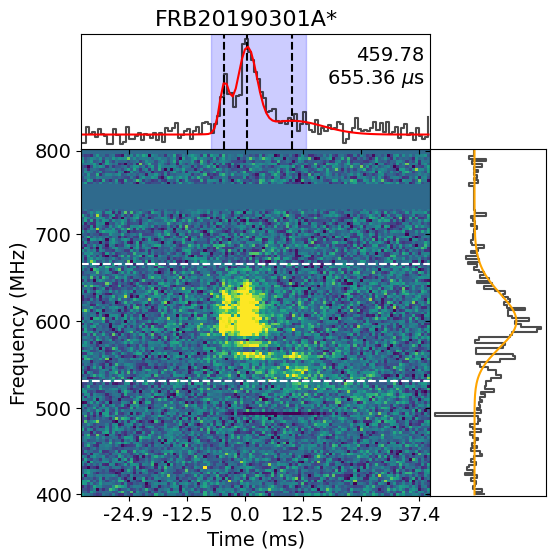

In [166]:
path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/'

for i in range(idx,idx+1):

    print("Running event", i, entries[i])
    event_path = os.path.join(path, str(entries[i]))

    spectra_input = event_path + '/model_bandwidth_{}.npz'.format(entries[i])

    data_spec = np.load(spectra_input, allow_pickle = True)


    model_ts = None
    print("Fit type is", fit_types[i])
    if fit_types[i] == 'Scint':
        burst_input = event_path + '/model_scint_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']
        bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
        left = bxcar['left']
        right= bxcar['right']

    if fit_types[i] == 'Scat':
        burst_input = event_path + '/model_scat_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']
        bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
        left = bxcar['left']
        right= bxcar['right']

    if fit_types[i] == 'Noscat':
        burst_input = event_path + '/model_no_scat_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']
        bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
        left = bxcar['left']
        right= bxcar['right']

    if fit_types[i] == 'Profile':
        print("getting the profile")
        burst_input = event_path + '/model_mcmc_profile_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_ts = data['model']
        model_wfall = None
        wfall = data['data']
        bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
        left = bxcar['left']
        right= bxcar['right']

    if fit_types[i] == 'Failed':
        try:
            print("getting the profile")
            burst_input = event_path + '/model_mcmc_profile_{}.npz'.format(entries[i])
            data = np.load(burst_input, allow_pickle = True)
            model_ts = data['model']
            model_wfall = None
            wfall = data['data']
            bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
            left = bxcar['left']
            right= bxcar['right']
        except:
            burst_input = event_path + '/model_scat_{}.npz'.format(entries[i])
            data = np.load(burst_input, allow_pickle = True)
            model_wfall = data['model']
            wfall = data['data']
            bxcar = np.load(event_path + f"/{entries[i]}_boxcar_r1.npz", allow_pickle=True)
            left = bxcar['left']
            right= bxcar['right']


    dm = dms[i]
    t_res = time_res[i]
    event = tns_name[i] ##### Replace with TNS name
    lo = low_freq[i]
    hi = high_freq[i]
    t_arr = data['arrival_time']*2#data['arrival_time']/4 #-> This for event 25281508, 40594289
    model_spec = data_spec['model']


    f_scrunch = 8
    t_scrunch = 1

    f_res = (400/1024)*f_scrunch 
    t_res = t_res * t_scrunch

    wfall = scrunch_npy(wfall, f_scrunch, t_scrunch)

    if model_wfall is not None:
        model_wfall = scrunch_npy(model_wfall, f_scrunch, t_scrunch)

    if model_spec is not None:
        model_spec = scrunch_spec(model_spec, f_scrunch)

    if model_ts is not None:
        model_ts = scrunch_spec(model_ts, t_scrunch)
        model_ts = model_ts * (np.sqrt(1024)/(f_scrunch)) #### This scales the profile with respect to channels


    save_fname = '/arc/home/ksand/Basecat_morph/Paper_plots/Wfalls/{}_{}_wfall.pdf'.format(entries[i], fit_types[i])
    
    plot_event(wfall, f_res, t_res, dm, event, save_fname = save_fname,
               model_wfall = model_wfall, low_freq=lo, high_freq=hi, 
               t_arr = t_arr, left = left, right = right+10, 
               model_spec = model_spec, model_ts = model_ts)
